## Setup

## **Installation**
Installation of langid, a language identifier library

In [ ]:
!pip install langid

     |████████████████████████████████| 1.9MB 18.7MB/s 
  Created wheel for langid: filename=langid-1.1.6-cp37-none-any.whl size=1941191 sha256=9fe98a923eaa898e019a9ec1337b14a778bc8d075940f815258b694d3598c22e
  Stored in directory: /root/.cache/pip/wheels/29/bc/61/50a93be85d1afe9436c3dc61f38da8ad7b637a38af4824e86e
Successfully built langid


In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import warnings
from tqdm import tqdm
from nltk import RegexpTokenizer
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 7)})
warnings.filterwarnings("ignore")
import nltk
import string
import datetime
from os.path import join, exists
import re
import operator
nltk.download('punkt')
from collections import Counter                                                                                         
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer       
from nltk.tokenize import TweetTokenizer   
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from plotly.offline import iplot
import scipy.sparse as sp
nltk.download('wordnet')
import spacy #  NLP library
import langid # language identification                         
from nltk.corpus import stopwords        
from nltk.stem.snowball import FrenchStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1b8wSli5rFL6wxokZeLAg0iVwJSFIjIOa'
download = drive.CreateFile({'id':id}) 
download.GetContentFile('groover_dataset_challenge.csv')  

# General statistics

In [ ]:
df_dataset = pd.read_csv('groover_dataset_challenge.csv', index_col=0)
df_dataset.head()

,id,band_id,influencer_id,feedback,score
0,920636,24665,1642,"Bonjour Diogo Ramos,\n\n\nMerci pour le partag...",0.0
1,920637,24665,118,"Un message touchant, développé sur une onde mu...",0.0
2,920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.0
3,920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.0
4,920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.0


The dataframe contains 10000 rows. We will perform a general statistics analysis on the following columns : **band_id**,	**influencer_id**,	**feedback** and the **score**.

In [ ]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   band_id        10000 non-null  int64  
 2   influencer_id  10000 non-null  int64  
 3   feedback       10000 non-null  object 
 4   score          10000 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 468.8+ KB


There is no null value in the dataframe

Number of unique bands and influencers

In [ ]:
n_band = df_dataset.band_id.unique().shape[0]
n_influencer = df_dataset.influencer_id.unique().shape[0]

print("Number of unique bands/artists :\t%.2f" % n_band)
print("Number of unique influencers:\t\t%.2f" % n_influencer)

Number of unique bands/artists :	970.00
Number of unique influencers:		898.00


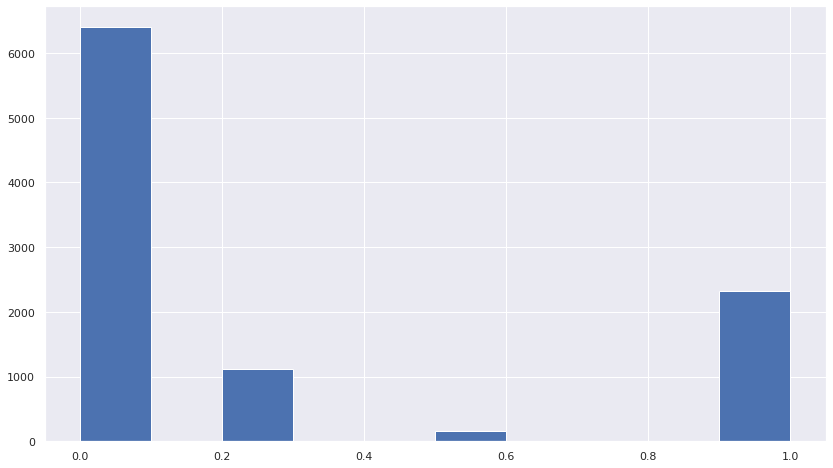

In [ ]:
plt.figure(figsize=(14, 8))
df_dataset.score.hist()

Most of the feebacks have the score 0. So influencers mostly do not liked the track that were sent to them by the artists.

Top 10 most rated bands/artists

In [ ]:
N = 10
band_dict = df_dataset.groupby('band_id').count()['score'].to_dict()
res = dict(sorted(band_dict.items(), key = operator.itemgetter(1), reverse = True)[:N]) 
top_band = pd.DataFrame(res.values(), index=res.keys(), columns=['Count'])
top_band.index.name='Band_id'
top_band

,Count
Band_id,
603,169
4942,168
3949,156
32787,134
8046,127
29227,124
6149,110
27284,108
31816,93


Top 10 influencers that have given feedback

In [ ]:
N = 10
influencer_dict = df_dataset.groupby('influencer_id').count()['score'].to_dict()
res_sorted = dict(sorted(influencer_dict.items(), key = operator.itemgetter(1), reverse = True)[:N]) 
top_influencer = pd.DataFrame(res_sorted.values(), index=res_sorted.keys(), columns=['Count'])
top_influencer.index.name='Influencer_id'
top_influencer

,Count
Influencer_id,
3592,87
385,81
2064,81
1675,69
1821,69
110,64
1642,58
226,55
784,54


In this section we will focus on the feedback column. Note that the column has not been yet been proprocessed and cleaned. The idea is just to plot a wordcloud and see word distribution. It would have been more relevant to plot the word distribution once we get rid of stopwords. Let's just recall that this is just an overvie. 

In [ ]:
# Transform a dataframe of string into a single string
def single_text(df_column):
  return ' '.join(df_column)

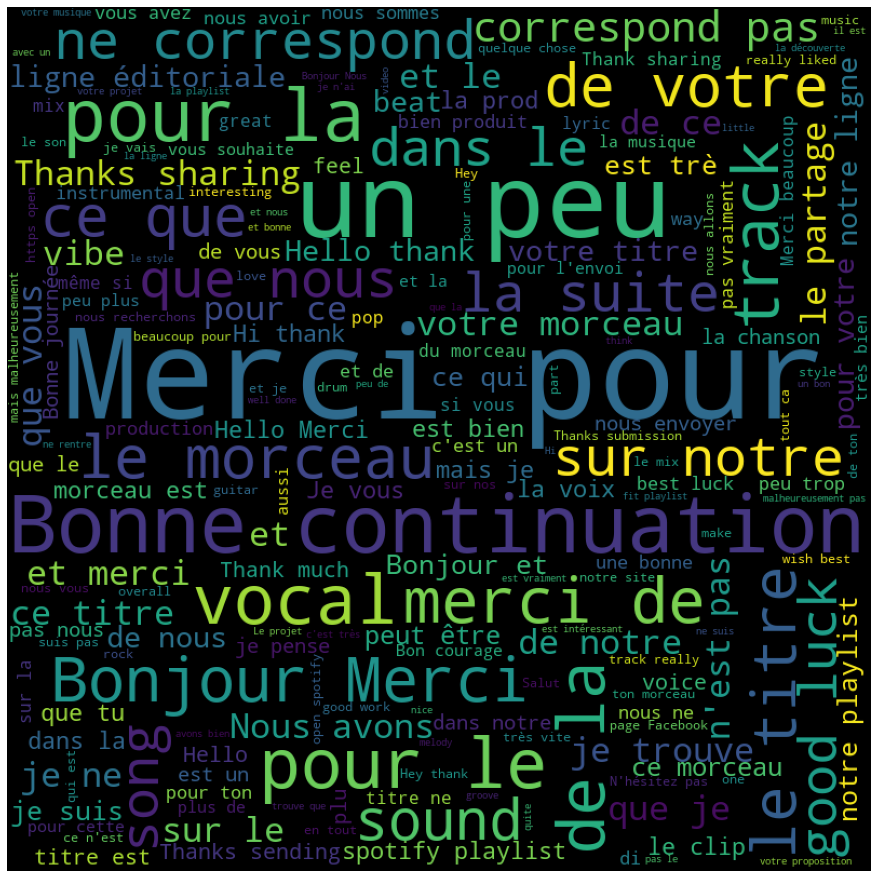

In [ ]:
# Words cloud of the feedback content
all_feedback = single_text(df_dataset['feedback'])
wordcloud_html_parse = WordCloud(width = 800, height = 800, background_color ='black').generate(all_feedback)
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud_html_parse)
plt.axis("off") 
plt.tight_layout(pad = 0)

In the feedback, there are at least two languages. Since we have 10000 feedback, we will use a language identifier library to identify the feedbacks' language. We use langid library

In [ ]:
# get the language id for each text
ids_langid = df_dataset.feedback.astype(str).apply(langid.classify)

# get just the language label
langs = ids_langid.apply(lambda tuple: tuple[0])

# how many unique language labels were applied?
print("Number of tagged languages (estimated):")
print(len(langs.unique()))

Number of tagged languages (estimated):
8


8 languages have been detected as you can see. Let's now plot the distribution

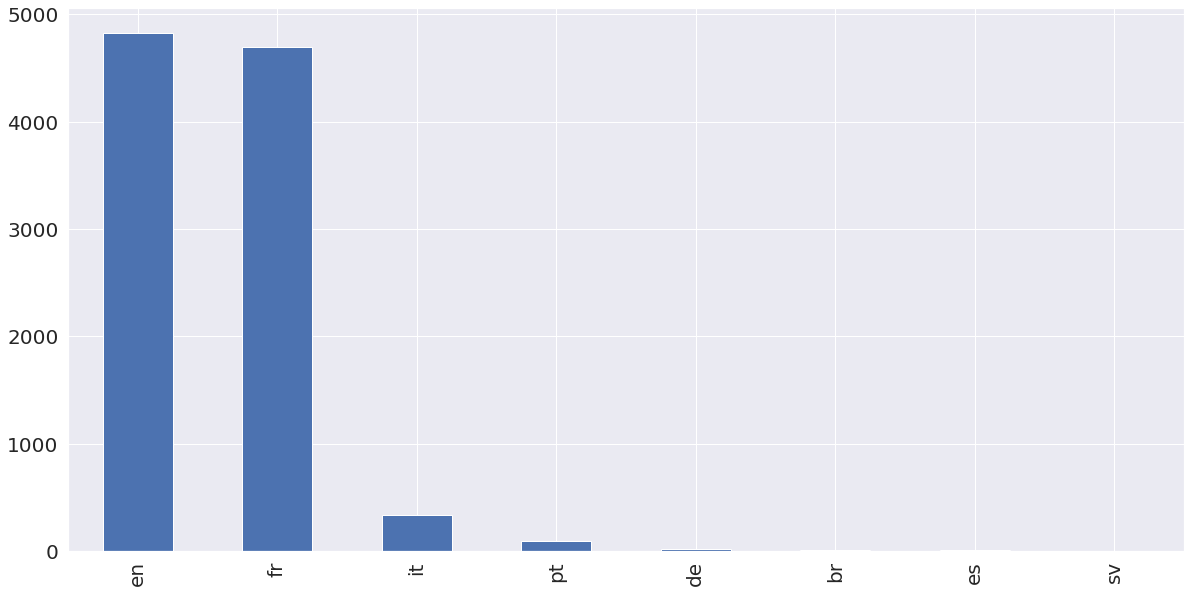

In [ ]:
# convert our list of languages to a dataframe
langs_df = pd.DataFrame(langs, columns=['language'])
#from collections import Counter

# convert our list of languages to a dataframe
langs_df = pd.DataFrame(langs)

# count the number of times we see each language
langs_count = langs_df.feedback.value_counts()

# horrible-looking barplot (I would suggest using R for visualization)
langs_count.plot.bar(figsize=(20,10), fontsize=20)

As expected, english and french are the most common language in the feedbacks. Each of these two languages represent almost halft of the dataset. We can either choose to work on only one language which implies to divide the dataframe by two or keep both and preprocess the whole dataframe. In both cases, we will not take into account the 6 other languages.

In [ ]:
langs_df.columns = ["language"]
df_dataset = df_dataset.join(langs_df)
df_dataset.head()

,id,band_id,influencer_id,feedback,score,language
0,920636,24665,1642,"Bonjour Diogo Ramos,\n\n\nMerci pour le partag...",0.0,fr
1,920637,24665,118,"Un message touchant, développé sur une onde mu...",0.0,fr
2,920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.0,fr
3,920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.0,fr
4,920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.0,fr


Let's only keep english and french feedbacks in our dataset

In [ ]:
df_en_fr = df_dataset[(df_dataset['language']=='en') | (df_dataset['language'] == 'fr')]
df_en_fr

,id,band_id,influencer_id,feedback,score,language
0,920636,24665,1642,"Bonjour Diogo Ramos,\n\n\nMerci pour le partag...",0.00,fr
1,920637,24665,118,"Un message touchant, développé sur une onde mu...",0.00,fr
2,920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.00,fr
3,920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.00,fr
4,920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.00,fr
...,...,...,...,...,...,...
9995,936179,30049,3499,"Hey guys, thanks for sharing, great sound, alt...",1.00,en
9996,936241,33795,2570,"Hello MD One, thank you for your track Bombe A...",0.00,en
9997,936266,18877,2598,Hi! Thanks for sharing your track! I really li...,1.00,en
9998,936274,18877,3179,This is an exceptionally produced electro-pop ...,0.25,en


We went from 10000 rows to 9518

# Natural Language Processing

In this section, we will try to preprocess and clean the feedback column. 
Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:
* Tokenizing the string
* Lowercasing
* Removing stop words and punctuation
* Lemmatizing/Stemming

Tokenization is the process of converting a sequence of strings into a sequence of tokens (words, symbols, keywords etc).
The next step is to clean up the tokenized sentence by filtering out stop words and punctuation. Stop words are those words that when removed in a sentence, they do not actually change its deeper meaning. For instance, when someone says "I am happy", removing the pronoun "I" doesn't change anything to the person emotions.
Lemmatization according to Wikipedia "is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form." For instance the words **working** and **worked** will be reduce to their lemma **work**


### **English preprocessing**

In [ ]:
# Import the english stop words list from NLTK
nltk.download('stopwords')
stopwords_english =   set(stopwords.words('english'))
stopwords_french = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The following function takes in sentence as argument to removes all punctuations, special characters and apostrophs (') for instance **"we're"** will be separated in **"we"** and **"'re"**. Strings are also lowercased.

In [ ]:
def clean_string(description):
  """
    This function takes in sentence as argument to removes all punctuations, special characters 
    and apostroph (') for instance "we're" will be separated in "we" and "'re". Strings are also lowercased
  """
  description = re.sub(r"[^A-Za-z0-9()_+,!?:\'\`]", " ", description)
  description = re.sub(r"\'s", " \'s", description)
  description = re.sub(r"\'ve", " \'ve", description)
  description = re.sub(r"n\'t", " n\'t", description)
  description = re.sub(r"\'re", " \'re", description)
  description = re.sub(r"\'d", " \'d", description)
  description = re.sub(r"\'ll", " \'ll", description)
  description = re.sub(r'[^\w\s]', '', description)
  return description.strip().lower()

In [ ]:
en_clean_string = df_en_fr[(df_en_fr['language']=='en')]
en_clean_string.feedback = en_clean_string['feedback'].apply(clean_string)

In [ ]:
en_clean_string.head(5)

,id,band_id,influencer_id,feedback,score,language
10,920648,24665,1406,hello and thanks for sharing your music with u...,0.0,en
11,920649,24665,1644,hello we have listened to your track unfortun...,0.0,en
12,920650,24665,3212,hi i liked the song it has a nice beat the ly...,0.0,en
14,920653,24665,1672,hi good news libert je taime as been added...,1.0,en
17,920656,24665,2417,hey thanks for sending out we ll pass on that...,0.0,en


In the next cell, english feebacks are tokenized and we remove stopwords.

In [ ]:
def preprocess_english(sentence):
  tokenizer = TweetTokenizer(preserve_case = False, strip_handles = True, reduce_len = True)
  wordnet_lemmatizer = WordNetLemmatizer()
  tokens = tokenizer.tokenize(sentence)
  clean = []
  for word in tokens:
    if (word not in stopwords_english and  
                word not in string.punctuation ):
      clean.append(wordnet_lemmatizer.lemmatize(word))
  return ' '.join([word for word in clean]).strip()

In [ ]:
en_clean_string.feedback = en_clean_string['feedback'].apply(preprocess_english)

In [ ]:
en_clean_string['feedback'][12]

'hi liked song nice beat lyric also interesting unfortunately still nt list mood good luck'

Below an example of a preprocess feedback. All punctuations and stop words have been removed. 

In [ ]:
en_clean_string['feedback'][22]

'like song lot actually mess overall production lack lot clarity mix maybe think hiring mixing engineer next time actually one add link hire low price another platform want send mail get information service like vocal tuning etc way song quality sharable level really dragging actual good overall song'

### **French preprocessing**

In [ ]:
def clean_string_fr(description):
  description = re.sub(r"[^A-Za-z0-9()_+,!?:\'\`]", " ", description)
  description= re.sub(r"c\'", "c '", description)
  description= re.sub(r"l\'", "l '", description)
  description= re.sub(r"n\'", "n '", description)
  description= re.sub(r"m\'", "m '", description)
  description = re.sub(r'[^\w\s]', '', description)
  return description.strip().lower()

In [ ]:
fr_clean_string = df_en_fr[(df_en_fr['language']=='fr')]
fr_clean_string.feedback = fr_clean_string['feedback'].apply(clean_string_fr)

In the next cell, english feebacks are tokenized and we remove stopwords. Besides, we also stem the word which may results in non existing words since stemmind reduce words to their roots and sometimes the result does not make any sense.

In [ ]:
def preprocess_french(sentence):
  toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
  tokens = toknizer.tokenize(sentence)
  stemmer = FrenchStemmer()
  clean = []
  for word in tokens:
    if (word not in stopwords_french and 
                word not in string.punctuation):
      clean.append(stemmer.stem(word))
  return ' '.join([word for word in clean]).strip()


In [ ]:
fr_clean_string.feedback = fr_clean_string['feedback'].apply(preprocess_french)

Combine the dataframe

In [ ]:
df_preprocessed = fr_clean_string.append(en_clean_string)

# Fitting into analysis

**Text embedding**

In Natural Language Processing, before building any model, we need to convert text into numbers. Indeed, since ML algorithms cannot work with raw text directly, the text has to be converted to vectors of numbers by for instance building a vocabulary that allows to encode any text as an array of numbers.

To encode a sentance into vectors, many approaches can be used. A vocabulary of unique words in the whole dataset can be built and we can used one hot enconding to embed each sentence. However, this results in a sparse vector with huge dimensions. Indeed, the vector representation size in this case grows with corpus. Another simple and common approach is to embed each word of the sentance (word embeddings) and average all vectors to obtain the sentance embedding. This latter approach results in loss of information. This is where Google's Universal Sentance Encoder comes into action. It provides us with a model that maps any given sentence to a fixed-length vector representation.

<img src="https://amitness.com/images/use-overall-pipeline.png" alt="drawing" width="900"/>

The Google's Universal Sentance Encoder was introduced in the following [paper](https://arxiv.org/abs/1803.11175) on April 2018, by a team of researchers at Google. The researchers provide two models to encode a sentence into vector. The first one uses a Transformer Architecture and the second one uses a Deep Average Network (DAN) to encode strings into embedding vectors. The implementation was done in Tensorflow. You can download the models here [USE](https://radimrehurek.com/gensim/index.html). 

Since in this section,  we mainly focus on transforming the feedbacks into vectors representation, we therefore can use the USE which take into account **semantic simarity**. Semantic similarity is a measure of the degree to which two pieces of text carry the same meaning. The Universal Sentance Encoder can be used to find out the relations between feedbacks in a our dataset. We can compare feedbavks, compute their similarity or even use the representation to perform sentiment analysis on the feedbacks.

Setting up the environment for Google's Universal Sentance Encoder. We use Tensorflow Hb (TF) to embed our text data into vector representation.

In [ ]:
import tensorflow_hub as hub
from absl import logging
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


Here are some examples that can be found in the documentation

In [ ]:
# Some examples
phrase1 = "I am a data scientist"
phrase2 = "I love eating pizza"

# Reduce logging output.
logging.set_verbosity(logging.ERROR)
messages = [phrase1, phrase2]
message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Vector size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Vector embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: I am a data scientist
Vector size: 512
Vector embedding: [0.05238805338740349, -0.07251499593257904, -0.021950194612145424, ...]

Message: I love eating pizza
Vector size: 512
Vector embedding: [0.06066170334815979, -0.029400642961263657, 0.0546661913394928, ...]



Wd compute a function that embed the whole dataset

In [ ]:
# Function to embed the whole dataset
def embed_dataset(s):
  return(embed([s]))

Let's use the english dataset. Note that both datasets can be used

In [ ]:
en_clean_string

,id,band_id,influencer_id,feedback,score,language
10,920648,24665,1406,hello thanks sharing music u honestly beautifu...,0.00,en
11,920649,24665,1644,hello listened track unfortunately crush good ...,0.00,en
12,920650,24665,3212,hi liked song nice beat lyric also interesting...,0.00,en
14,920653,24665,1672,hi good news libert je taime added playlist to...,1.00,en
17,920656,24665,2417,hey thanks sending pas one unfortunately reall...,0.00,en
...,...,...,...,...,...,...
9994,936174,30049,1077,hi de thank much submitting music great track ...,0.00,en
9995,936179,30049,3499,hey guy thanks sharing great sound although fo...,1.00,en
9996,936241,33795,2570,hello md one thank track bombe certainly hear ...,0.00,en
9997,936266,18877,2598,hi thanks sharing track really like song reall...,1.00,en


In [ ]:
# Embedding of feedbacks 
en_clean_string['embedded'] = en_clean_string['feedback'].apply(embed_dataset)

In [ ]:
en_clean_string.head()

,id,band_id,influencer_id,feedback,score,language,embedded
10,920648,24665,1406,hello thanks sharing music u honestly beautifu...,0.0,en,"((tf.Tensor(-0.0031998283, shape=(), dtype=flo..."
11,920649,24665,1644,hello listened track unfortunately crush good ...,0.0,en,"((tf.Tensor(-0.025218066, shape=(), dtype=floa..."
12,920650,24665,3212,hi liked song nice beat lyric also interesting...,0.0,en,"((tf.Tensor(-0.029604774, shape=(), dtype=floa..."
14,920653,24665,1672,hi good news libert je taime added playlist to...,1.0,en,"((tf.Tensor(-0.07797158, shape=(), dtype=float..."
17,920656,24665,2417,hey thanks sending pas one unfortunately reall...,0.0,en,"((tf.Tensor(-0.021743257, shape=(), dtype=floa..."


The embedded column is a tensor. Let's convert it into an array

In [ ]:
# Transform our embeded vectors into array
def get_embeddings_as_list(T):
    return np.array(T).tolist()[0]

In [ ]:
# Add embedded vectors to our dataset
en_clean_string['final_vector'] = en_clean_string['embedded'].apply(get_embeddings_as_list)
en_clean_string

,id,band_id,influencer_id,feedback,score,language,embedded,final_vector
10,920648,24665,1406,hello thanks sharing music u honestly beautifu...,0.00,en,"((tf.Tensor(-0.0031998283, shape=(), dtype=flo...","[-0.0031998283229768276, 0.046112317591905594,..."
11,920649,24665,1644,hello listened track unfortunately crush good ...,0.00,en,"((tf.Tensor(-0.025218066, shape=(), dtype=floa...","[-0.025218065828084946, 0.048612624406814575, ..."
12,920650,24665,3212,hi liked song nice beat lyric also interesting...,0.00,en,"((tf.Tensor(-0.029604774, shape=(), dtype=floa...","[-0.029604773968458176, -0.009327733889222145,..."
14,920653,24665,1672,hi good news libert je taime added playlist to...,1.00,en,"((tf.Tensor(-0.07797158, shape=(), dtype=float...","[-0.07797157764434814, -0.01982223428785801, 0..."
17,920656,24665,2417,hey thanks sending pas one unfortunately reall...,0.00,en,"((tf.Tensor(-0.021743257, shape=(), dtype=floa...","[-0.021743256598711014, 0.042117442935705185, ..."
...,...,...,...,...,...,...,...,...
9994,936174,30049,1077,hi de thank much submitting music great track ...,0.00,en,"((tf.Tensor(-0.068849556, shape=(), dtype=floa...","[-0.06884955614805222, -0.004687161184847355, ..."
9995,936179,30049,3499,hey guy thanks sharing great sound although fo...,1.00,en,"((tf.Tensor(-0.06104241, shape=(), dtype=float...","[-0.061042409390211105, 0.061608608812093735, ..."
9996,936241,33795,2570,hello md one thank track bombe certainly hear ...,0.00,en,"((tf.Tensor(-0.0634337, shape=(), dtype=float3...","[-0.0634336993098259, -0.04677565023303032, 0...."
9997,936266,18877,2598,hi thanks sharing track really like song reall...,1.00,en,"((tf.Tensor(0.02254688, shape=(), dtype=float3...","[0.022546879947185516, 0.05712234601378441, 0...."


We can now get rid of the column **embedded**

In [ ]:
del en_clean_string['embedded']
en_clean_string.head()

,id,band_id,influencer_id,feedback,score,language,final_vector
10,920648,24665,1406,hello thanks sharing music u honestly beautifu...,0.0,en,"[-0.0031998283229768276, 0.046112317591905594,..."
11,920649,24665,1644,hello listened track unfortunately crush good ...,0.0,en,"[-0.025218065828084946, 0.048612624406814575, ..."
12,920650,24665,3212,hi liked song nice beat lyric also interesting...,0.0,en,"[-0.029604773968458176, -0.009327733889222145,..."
14,920653,24665,1672,hi good news libert je taime added playlist to...,1.0,en,"[-0.07797157764434814, -0.01982223428785801, 0..."
17,920656,24665,2417,hey thanks sending pas one unfortunately reall...,0.0,en,"[-0.021743256598711014, 0.042117442935705185, ..."


----

We have now a column that contains its feeback vector representation. This can be used to fit any machine learning model. 

----

# Example of what can be done with these vectors

Once we have a vector representation, we can use the these vectors to fit as said above any machine learning model. For instance a simple clustering with KMeans algorithm. To do so, I just performed an unsupervised clustering, in order to know the best number of clusters I used the elbow method on the inertia graph.

100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


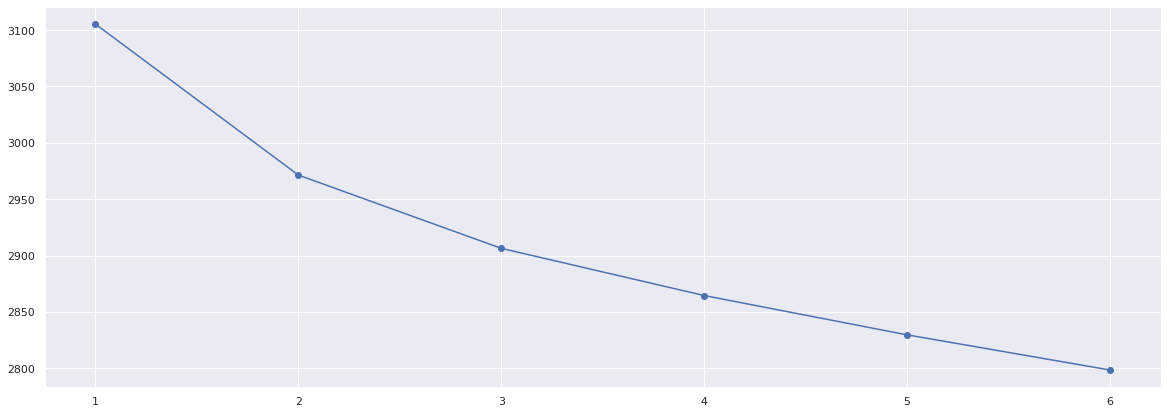

In [ ]:
# Elbow method for emails' subject
from sklearn.cluster import KMeans
a = []
for i in tqdm(range(1,7)):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(np.array(en_clean_string['final_vector']).tolist())
    a.append(kmeans.inertia_)
plt.scatter(range(1,7), a)
plt.plot(range(1,7), a)

The appropriate number of clusters is 2. This result can be explained by the fact that feedbacks are either postive (influencer liked the track sent by the artist) or negative (he or she didn't really like it). 